<h1 align="center">Volume 4: Total Variation.</h1>

    Jane Slagle
    Section 1
    2/20/23

In [51]:
import numpy as np
from matplotlib import pyplot as plt
from numpy.linalg import norm
from numpy.random import randint, uniform, randn
from matplotlib import cm
from imageio import imread, imwrite

# Problem 1

Using $20$ $x$ steps, $250$ time steps, $a=-1$, $b=1$, $\alpha = 1$, $\beta=7$, and a final time of $0.2$, plot the solution that minimizes (18.4). It should match figure 17.1.

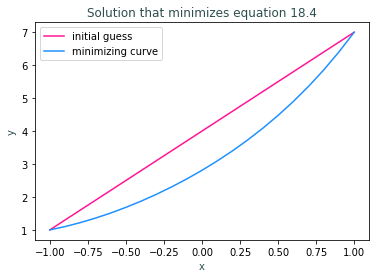

In [58]:
#first create grid, set our end states below:
a, b = -1, 1.
alpha, beta = 1., 7.
final_T = 0.2
x_steps, time_steps = 20, 250

#define variables x_steps, final_T, time_steps
delta_t, delta_x = final_T/time_steps, (b-a)/x_steps
x0 = np.linspace(a,b,x_steps+1)

#check a stability condition for this numerical method
if delta_t/delta_x**2. > .5:
    print("stability condition fails")

#use straight line connecting end pts. as initial data:
u = np.empty((2,x_steps+1))
u[0] = (beta - alpha)/(b-a)*(x0-a) + alpha
u[1] = (beta - alpha)/(b-a)*(x0-a) + alpha

u_before = u.copy()  #will need for plotting 

#define the right hand side of our difference scheme
def rhs(y):
    # Approximate first and second derivatives to second order accuracy.
    yp = (np.roll(y,-1) - np.roll(y,1))/(2.*delta_x)
    ypp = (np.roll(y,-1) - 2.*y + np.roll(y,1))/delta_x**2.
    # Find approximation for the next time step, using a first order Euler step
    y[1:-1] -= delta_t*(1. + yp[1:-1]**2. - 1.*y[1:-1]*ypp[1:-1])
    
#time step until scheme converges, until successive iterations are close
iteration = 0
while iteration < time_steps:
    rhs(u[1])
    if norm(np.abs((u[0] - u[1]))) < 1e-5: break
    u[0] = u[1]
    iteration+=1
      
#plot u before all the rhs stuff and after (after we have the solution) bc Sean says Jared told him to do this:
plt.plot(x0, u_before[0], label = "initial guess", color = "deeppink")  #u is (x,y), only want x so do u[0]
plt.plot(x0, u[0], label = "minimizing curve", color = "dodgerblue")
plt.xlabel("x", color = "darkslategray")
plt.ylabel("y", color = "darkslategray")
plt.legend(loc = "best")
plt.title("Solution that minimizes equation 18.4", color = "darkslategray")
plt.show()

# Problem 2

Using $\Delta t = 1e{-3},$ $\lambda = 40,$ $\Delta x = 1,$ and $\Delta y = 1$, implement the numerical scheme mentioned above to obtain a solution $u$. (So $\Omega = [0,n_x]\times [0,n_y]$, where $n_x$ and $n_y$ represent the number of pixels in the $x$ and $y$ dimensions, respectively.) Take 250 steps in time. Plot the original image as well as the image with noise. Compare your results with Figure 17.3.

Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


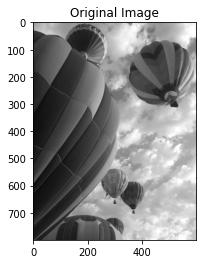

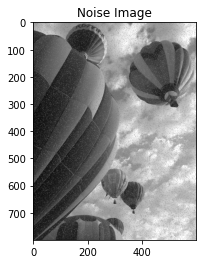

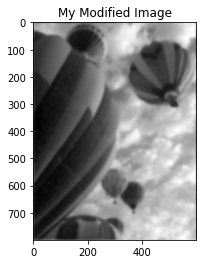

In [97]:
#copy code they gave in lab manual and modify it so working w/ file given in folder and so that have
#all correct parameters for delta_t, time_steps, etc. given in the problem

imagename = 'balloons_color.jpg'
changed_pixels=40000
# Read the image file imagename into an array of numbers, IM
# Multiply by 1. / 255 to change the values so that they are floating point
# numbers ranging from 0 to 1.
IM = imread(imagename, as_gray=True) * (1. / 255)
IM_OG = IM.copy()     #make copy of the OG image before make any changes to it!
IM_x, IM_y = IM.shape

for lost in range(changed_pixels):
    x_,y_ = randint(1,IM_x-2), randint(1,IM_y-2)
    val = .1*randn() + .5
    IM[x_,y_] = max( min(val,1.), 0.)
    
imwrite("noised_"+imagename, IM)

#want solution of u, but in lab manual we see that this means we need u and f (like in below eq. 18.5)
#f and u here are the image!
#define all variables have:
f = np.copy(IM)
u = np.copy(IM)

delta_t = 1e-03
lam = 40
delta_x = 1
delta_y = 1
nx, ny = IM.shape  #get omega domain thing
time_steps = 250

#have rhs func just like in prob 1, but need modify the rhs func bc rhs func is where get the sol of u
def rhs(u_t):  #want approx. u_t here
    #getting the u_xx, u_yy, u_t equations that are right under eq. 18.6 in lab manual:
    u_xx = np.roll(u, -1, axis=1) - 2*u + np.roll(u, 1, axis=1)
    u_yy = np.roll(u, -1, axis=0) - 2*u + np.roll(u, 1, axis=0)
    u_t = u_t + delta_t * (-u_t + f + lam * (u_xx + u_yy))
    
    return u_t  #want return u_t bc it's what we are approximating here

#time step until scheme converges, until successive iterations are close
#need to modify this too
iteration = 0
while iteration < time_steps:
    u_new = rhs(u)
    if norm(np.abs((u - u_new))) < 1e-5: break
    u = u_new
    iteration+=1
    
#plot OG and noise image:
plt.title("Original Image")
plt.imshow(IM_OG, cmap = 'gray')
plt.show()

#Bryce told us to plot this so I guess I will
plt.title("Noise Image")
plt.imshow(IM, cmap = 'gray')
plt.show()

#now plot the image I made:
plt.title("My Modified Image")
plt.imshow(u, cmap = "gray")
plt.show()

In [98]:
prob_2_ans = np.copy(u)

# Problem 3

Using $\Delta t = 1e-3, \lambda = 1, \Delta x = 1,$ and $ \Delta y = 1$, implement the numerical scheme mentioned above to obtain a solution $u$.  Take 200 steps in time. Display both the diffusion-based and total variaton images of the balloon. Compare your results with
Figure 17.3. How small should ε be?

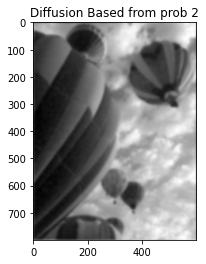

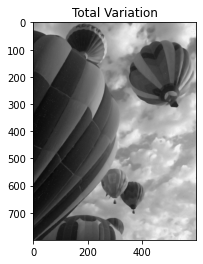

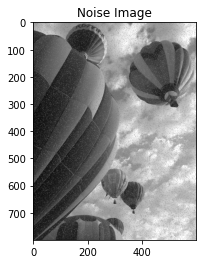

In [105]:
#define all variables have:
u = np.copy(IM)
lam = 1
delta_t = 1e-03
time_steps = 200

#update w/ rhs func again: want update w/ eq. 18.11, need u_xx, u_yy, u_x, u_y, u_xy for that equation
def rhs(u_t):
    #get all components need for eq. 18.11:
    u_x = (np.roll(u,-1,axis=1) - np.roll(u,1,axis=1))/2
    u_y = (np.roll(u, -1, axis = 0) - np.roll(u, 1, axis = 0))/2
    
    u_xx = np.roll(u,-1,axis=1) - 2*u + np.roll(u,1,axis=1)
    u_yy = np.roll(u,-1,axis=0) - 2*u + np.roll(u,1,axis=0)
    
    u_xy = (np.roll(u_x,-1,axis=0) - np.roll(u_x,1,axis=0))/2.
    
    #get numerator and denominator term that have in eq. 18.11:
    numerator = (u_xx * u_y**2 + u_yy * u_x**2 - 2 * u_x * u_y * u_xy)
    denom = (1e-04 + u_x ** 2 + u_y **2)**(3/2)   #told need 1e-04 to avoid some divide by 0 error or something
    
    #now actually get eq. 18.11:
    u_t = u_t + delta_t * (-lam*(u_t - f) + numerator/denom)
    
    return u_t   #return the approximation now
    
#use same iteration as problem 2
iteration = 0
while iteration < time_steps:
    u_new = rhs(u)
    if norm(np.abs((u - u_new))) < 1e-5: break
    u = u_new
    iteration+=1
    
#want plot diffusion based and total variation images of balloon:
plt.title("Diffusion Based from prob 2")
plt.imshow(prob_2_ans, cmap = "gray")
plt.show()

plt.title("Total Variation")  #total variation is answer from this problem
plt.imshow(u, cmap = "gray")
plt.show()

plt.title("Noise Image")
plt.imshow(IM, cmap = "gray")
plt.show()